In [23]:
import load_data_multitox as ld
import dataloaders_sigma as dl
from Model_train_test_regression import Net, EarlyStopping, train, test

import pandas as pd
import numpy as np

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

import sys 
import os
import glob

from sklearn.model_selection import train_test_split

from tensorboardX import SummaryWriter

import time
from sklearn.preprocessing import MinMaxScaler#StandardScaler

import json

import matplotlib.pyplot as plt

# number of conformers created for every molecule
NUM_CONFS = 100

# amount of chemical elements taking into account
AMOUNT_OF_ELEM = 9

# amount of target values
TARGET_NUM = 29

#dataset folder
# DATASET_PATH="~/Tox21-MultiTox/MultiTox"
DATASET_PATH="./"

#logs path
LOG_PATH=os.path.join(DATASET_PATH,"logs_sigma_right")


#models path
MODEL_PATH=os.path.join(DATASET_PATH,"models_sigma_right")

In [3]:
EXPERIMENT_NUM=19

In [4]:
path="./"

In [5]:
with open(os.path.join(path,"logs_sigma_right",'exp_'+str(EXPERIMENT_NUM),str(EXPERIMENT_NUM)+'_parameters.json'),'r') as f:
  args = json.load(f)

In [6]:
args

{'EPOCHS_NUM': 100,
 'PATIENCE': 25,
 'SIGMA': 1.2,
 'BATCH_SIZE': 128,
 'TRANSF': 'g',
 'NUM_EXP': '19',
 'VOXEL_DIM': 50,
 'LEARN_RATE': 1e-05,
 'SIGMA_TRAIN': False}

In [34]:
LOG_PATH = os.path.join(LOG_PATH,'exp_'+str(EXPERIMENT_NUM))

MODEL_PATH = os.path.join(MODEL_PATH,'exp_'+str(EXPERIMENT_NUM))


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

print('Start loading dataset...')

# get dataset without duplicates from csv
data = pd.read_csv(os.path.join(DATASET_PATH,'database', 'MultiTox.csv'))
props = list(data)[1:]
scaler = MinMaxScaler()
data[props]=scaler.fit_transform(data[props])

# create elements dictionary
#     elements = ld.create_element_dict(data, amount=AMOUNT_OF_ELEM+1)
elements={'N':0,'C':1,'Cl':2,'I':3,'Br':4,'F':5,'O':6,'P':7,'S':8}

# read databases to dictionary
#     conf_calc = ld.reading_sql_database(database_dir='./dat/')
with open(os.path.join(DATASET_PATH,'many_elems.json'), 'r') as fp:
    conf_calc = json.load(fp)

keys=list(conf_calc.keys())
print ('Initial dataset size = ', len(keys))

new_conf_calc={}
for smiles in conf_calc.keys():
    for conf_num in conf_calc[smiles]:
        if smiles in new_conf_calc.keys():
            new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]
        else:
            new_conf_calc[smiles]={}
            new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]

conf_calc=new_conf_calc

elems = []
for key in keys:
    conformers=list(conf_calc[key].keys())
    for conformer in conformers:
        try:
            energy = conf_calc[key][conformer]['energy']
            elems = list(set(elems+list(conf_calc[key][conformer]['coordinates'].keys())))
        except:
            del conf_calc[key][conformer]
    if set(conf_calc[key].keys())!=set(range(100)):
          del conf_calc[key]
    elif conf_calc[key]=={}:
        del conf_calc[key]

print ('Post-processed dataset size = ', len(list(conf_calc.keys())))
# create indexing and label_dict for iteration
indexing, label_dict = ld.indexing_label_dict(data, conf_calc)
# print('Dataset has been loaded, ', int(time.time()-start_time),' s')

# start_time=time.time()
# create train and validation sets' indexes
print('Neural network initialization...')


Using device: cuda:0

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Start loading dataset...
Initial dataset size =  13091
Post-processed dataset size =  13084
Neural network initialization...


In [15]:
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                     np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                     random_state=115)

train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'],print_name=True)
train_generator = td.DataLoader(train_set, batch_size=1, shuffle=True)

test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'],print_name=True)
test_generator = td.DataLoader(test_set, batch_size=1, shuffle=True)

In [11]:
def plot_visualization(data,model,elements,grad_step=10**3,name=''):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}
    print(name)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[0].set_title('Molecule projection')
    ax[1].imshow((data-grad_step*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[1].set_title('Molecule Gradient descent')
    with torch.no_grad():
        gauss_blur = model.blur(data)

    ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[2].set_title('Blurred molecule')
    plt.show()
    
    molecules = data.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Atom types in molecule')
    plt.show()
    
    molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules_blur):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Blurred atom types in molecule')
    plt.show()
    
    grads = data.grad.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(grads):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
    fig.suptitle('Grads for atom types in molecule')    
    plt.show()
    

In [12]:
def plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name=''):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}
    print(name)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    data=model.x_input
    
    ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[0].set_title('Molecule projection')
    ax[1].imshow((data-grad_step*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[1].set_title('Molecule Gradient descent')
    with torch.no_grad():
        gauss_blur = model.blur(data)

    ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[2].set_title('Blurred molecule')
    plt.show()
    
    molecules = data.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Atom types in molecule')
    plt.show()
    
    molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules_blur):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Blurred atom types in molecule')
    plt.show()
    
    grads = data.grad.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(grads):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
    fig.suptitle('Grads for atom types in molecule')    
    plt.show()
    
    

In [32]:
os.listdir(MODEL_PATH)

['exp_20',
 'exp_23',
 'exp_22',
 'exp_16',
 'exp_25',
 'exp_19',
 'exp_21',
 'exp_24',
 'exp_18']

In [60]:
from torch.autograd import Variable
for batch_idx, (molecule, target) in enumerate(train_generator):
    if batch_idx<9:
        continue
    molecule = Variable(molecule.to(device),requires_grad=True)
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
    model=model.to(device)
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
    model.x_input=Parameter(molecule,requires_grad=True)
    target = target.to(device)
    # set gradients to zero
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    
    break

CC(=O)OC(C)c1ccccc1
C/C(NNC(N)=S)=C(\N=O)Nc1ccc(C)cc1
CC(=O)ON=C1C=CC(=O)C(=O)C=C1
CC(C)NCC(O)COc1nccc(NCc2ccccc2)c1C#N
CC(=O)OC/C(I)=C(\I)COC(C)=O
CC(C)OC(=O)C=Cc1ccc([N+](=O)[O-])o1
CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C)[C@H]3C[C@H](OC(C)=O)[C@@H]4[N+]3(C)CCCCC3)[C@@]2(C)C[C@@H]1[N+]1(C)CCCCC1
BrC(CNCc1ccccc1)c1ccccc1
CC1(C(CCO)C(=O)NCCc2ccccc2)OCCO1
C#CC(OC(=O)C1C(C=C(C)C)C1(C)C)/C(C)=C/CC


In [61]:
for name, param in model.named_parameters():
    print(name, type(param.data), param.size())

x_input <class 'torch.Tensor'> torch.Size([1, 9, 50, 50, 50])
conv1.weight <class 'torch.Tensor'> torch.Size([32, 9, 3, 3, 3])
conv1.bias <class 'torch.Tensor'> torch.Size([32])
conv2.weight <class 'torch.Tensor'> torch.Size([64, 32, 3, 3, 3])
conv2.bias <class 'torch.Tensor'> torch.Size([64])
conv3.weight <class 'torch.Tensor'> torch.Size([128, 64, 3, 3, 3])
conv3.bias <class 'torch.Tensor'> torch.Size([128])
conv4.weight <class 'torch.Tensor'> torch.Size([256, 128, 3, 3, 3])
conv4.bias <class 'torch.Tensor'> torch.Size([256])
fc1.weight <class 'torch.Tensor'> torch.Size([128, 256])
fc1.bias <class 'torch.Tensor'> torch.Size([128])
fc2.weight <class 'torch.Tensor'> torch.Size([29, 128])
fc2.bias <class 'torch.Tensor'> torch.Size([29])


In [63]:
loss.backward()

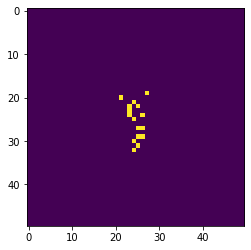

In [64]:
plt.imshow(model.x_input.sum(dim=0).sum(dim=0).sum(dim=0).cpu().detach().numpy())

CC(=O)Oc1ccc(CCN(C)C)cc1OC(C)=O


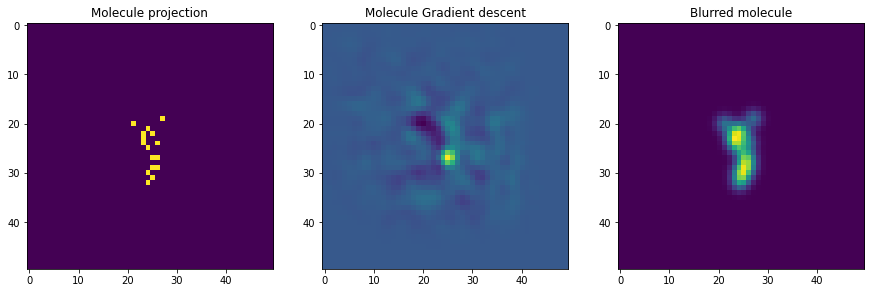

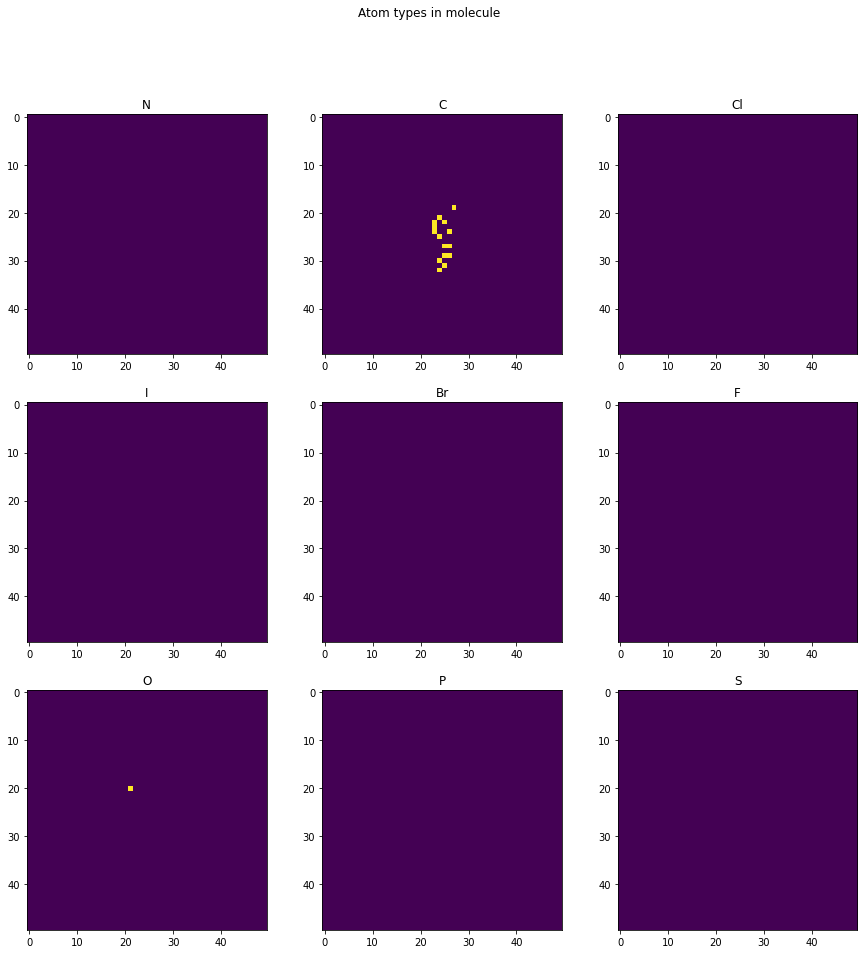

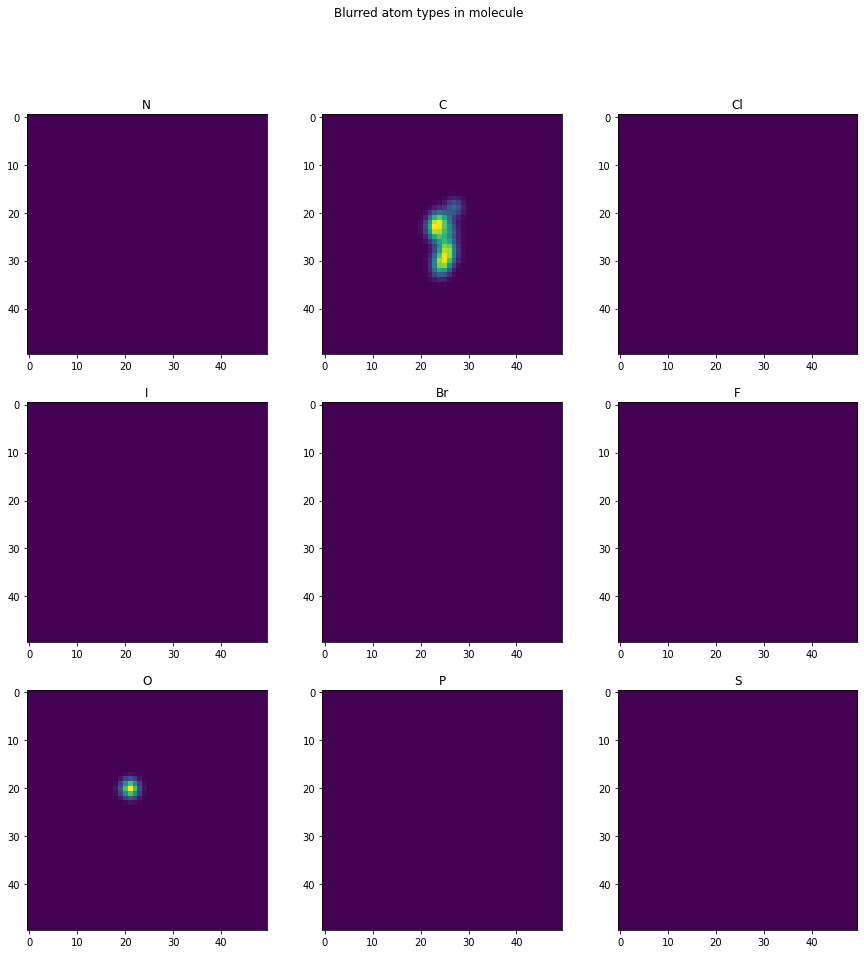

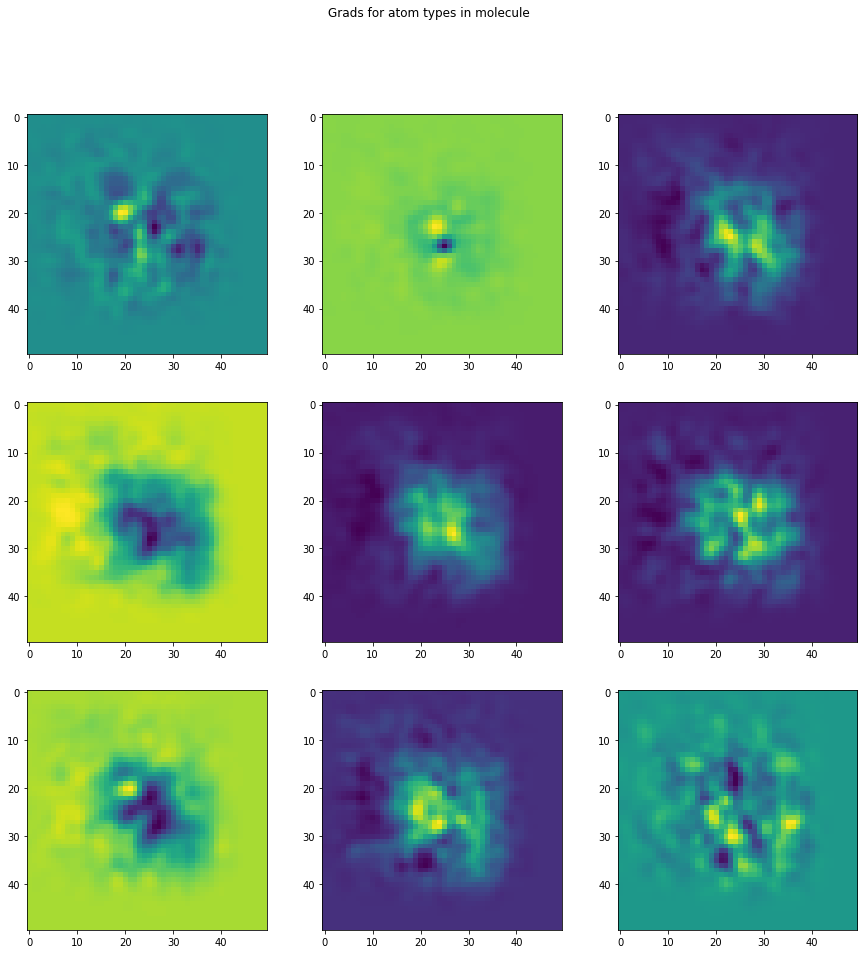

In [65]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='CC(=O)Oc1ccc(CCN(C)C)cc1OC(C)=O')